In [ ]:
<div style="text-align: center;">
  <h1>Stock /h1>
  <h2>Aurobindo Parida</h2>
</div>

In [6]:
# Make sure that you have all these libaries available to run the code successfully

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = yf.download('TSLA').reset_index()
df = df[(df['Date'] >= "2012-01-01") & (df['Date'] <= "2023-03-12")].reset_index(drop=True)

[*********************100%%**********************]  1 of 1 completed


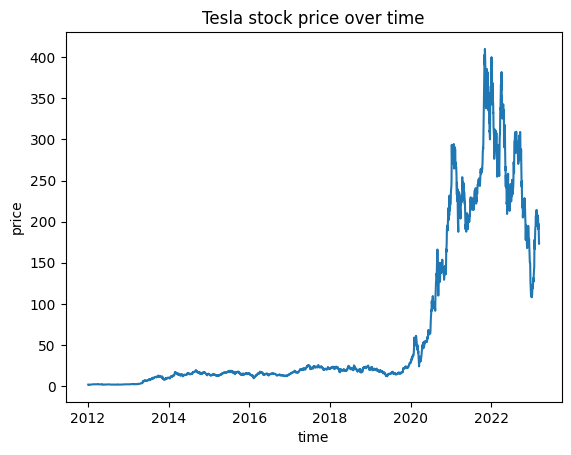

In [9]:
plt.plot(df["Date"], df["Close"])
plt.title("Tesla stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [10]:
# scaling the closing price
# MinMaxScaler => y = (y - min(y))/(min(y) - max(y))
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

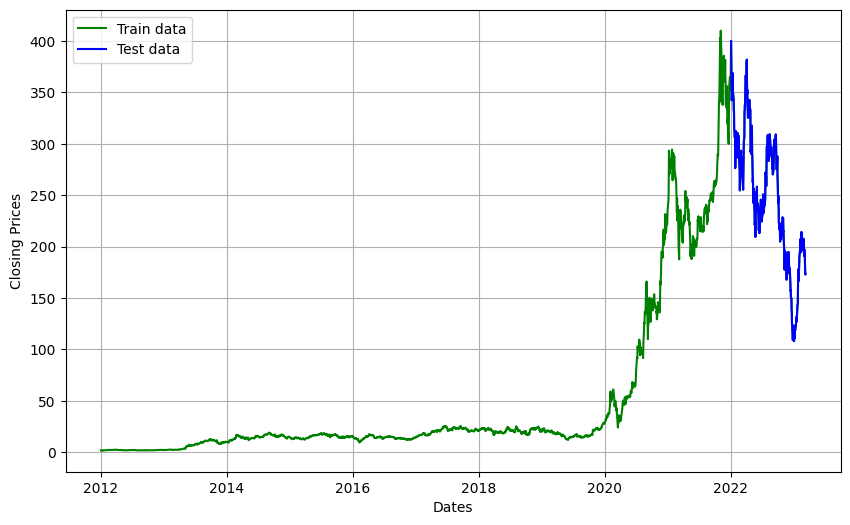

In [11]:
# split data into train and training set
train_data = df[df['Date'] < '2022-01-01']
test_data = df[df['Date'] >= '2022-01-01']

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'], df['Close'], 'green', label='Train data')
plt.plot(test_data['Date'], test_data['Close'], 'blue', label='Test data')
plt.legend()

In [12]:
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
x_test = []
y_test = test_data['scaled_values']

for i in range(60, len(test_data)):
    x_test.append(test_data['scaled_values'][i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [15]:
# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10

77/77 [==============================] - 11s 71ms/step - loss: 0.0044
Epoch 2/10
77/77 [==============================] - 4s 54ms/step - loss: 0.0015
Epoch 3/10
77/77 [==============================] - 4s 55ms/step - loss: 0.0017
Epoch 4/10
77/77 [==============================] - 4s 52ms/step - loss: 0.0016
Epoch 5/10
77/77 [==============================] - 4s 48ms/step - loss: 0.0014
Epoch 6/10
77/77 [==============================] - 4s 48ms/step - loss: 0.0015
Epoch 7/10
77/77 [==============================] - 4s 47ms/step - loss: 0.0015
Epoch 8/10
77/77 [==============================] - 4s 54ms/step - loss: 0.0017
Epoch 9/10
77/77 [==============================] - 5s 62ms/step - loss: 0.0015
Epoch 10/10
77/77 [==============================] - 5s 61ms/step - loss: 0.0012


In [18]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 17ms/step


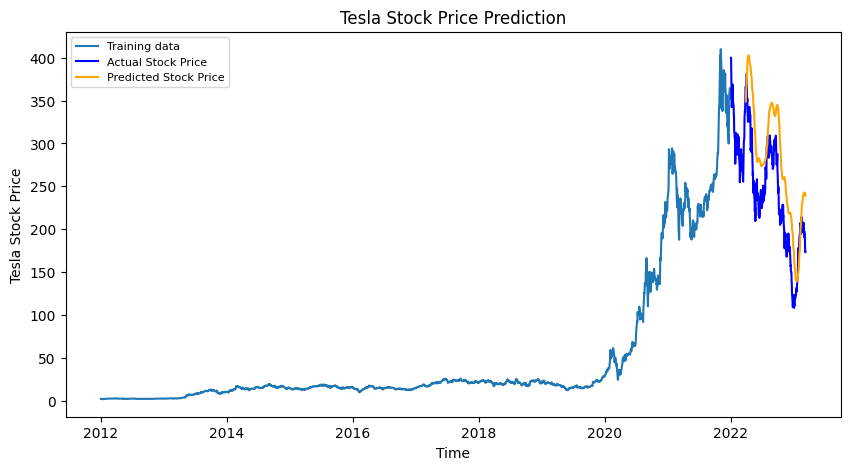

In [19]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], predicted_stock_price, color = 'orange',label='Predicted Stock Price')

plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math

y_true = test_data[60:]['Close'].values
y_pred = predicted_stock_price

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 2976.7389902474965
MAE: 48.192429935230926
RMSE: 54.55949954176171
MAPE: 0.42953394004957746
